In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt

In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0
...,...,...,...,...,...,...,...,...,...,...
44000,35,UNI,Unicaja,2021-03-24,0.802000,0.822000,0.786500,0.819500,0.751219,2616012
44001,35,UNI,Unicaja,2021-03-23,0.770000,0.807500,0.762500,0.802500,0.735636,2436213
44002,35,UNI,Unicaja,2021-03-22,0.780000,0.780500,0.760000,0.764000,0.700343,1420069
44003,35,UNI,Unicaja,2021-03-30,0.867000,0.878500,0.855500,0.877500,0.804387,3028721


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

acs = df[df['empresa'] == 'Grupo ACS']

acs.shape

(1325, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

acs = acs [['date','open','high','low','close','adj close']]

acs.shape

(1325, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

acs['date'] = pd.to_datetime(acs['date'], format="%Y-%m-%d")

acs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 3325 to 4649
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

acs.sort_values(by='date',ascending= True, inplace=True)

acs.head()

,date,open,high,low,close,adj close
3987,2019-01-02,33.282990,33.282990,32.245056,32.857929,22.656153
3986,2019-01-03,32.521839,33.243446,32.422989,32.937012,22.710680
3985,2019-01-04,33.312641,33.599312,33.184135,33.431263,23.051476
3984,2019-01-07,33.708046,33.905746,33.243446,33.539997,23.126450
3983,2019-01-08,33.530113,34.231953,33.451035,33.885979,23.365011


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

acs = acs[(acs['date'] >= fecha_inicio) & (acs['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

acs.shape

(812, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=acs['date'].min(), end=acs['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

acs = acs.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

acs = acs.rename(columns={'index': 'date'})

In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

acs.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,27.174023,27.816551,26.580919,26.699539,21.062082
1,2021-01-05,26.482067,27.144367,26.442528,27.134481,21.405190
2,2021-01-06,27.371723,28.093332,27.302528,27.727587,21.873060
3,2021-01-07,27.945057,27.994482,27.243217,27.421148,21.631327
4,2021-01-08,27.628735,27.885748,27.421148,27.490343,21.685913
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,27.490343,28.053793,27.391495,27.806665,21.935446
8,2021-01-12,27.925287,28.864367,27.777012,28.795172,22.715235
9,2021-01-13,28.795172,28.805058,28.192183,28.320688,22.340935


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

acs = acs.fillna(method='ffill')

In [11]:
# Paso 11: Establecer columna 'date' como índice para modelo

acs = acs.set_index('date')

acs.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,27.174023,27.816551,26.580919,26.699539,21.062082
2021-01-05,26.482067,27.144367,26.442528,27.134481,21.405190
2021-01-06,27.371723,28.093332,27.302528,27.727587,21.873060
2021-01-07,27.945057,27.994482,27.243217,27.421148,21.631327
2021-01-08,27.628735,27.885748,27.421148,27.490343,21.685913
2021-01-09,27.628735,27.885748,27.421148,27.490343,21.685913
2021-01-10,27.628735,27.885748,27.421148,27.490343,21.685913
2021-01-11,27.490343,28.053793,27.391495,27.806665,21.935446
2021-01-12,27.925287,28.864367,27.777012,28.795172,22.715235


In [12]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

acs.index = pd.DatetimeIndex(acs.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

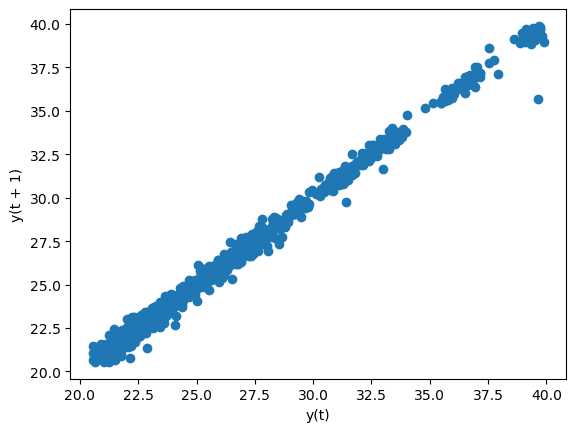

In [13]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

from pandas.plotting import lag_plot

lag_plot(acs.close)

In [14]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [15]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = acs.close[:-10], acs.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [16]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [17]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(acs.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    36.633690
2024-02-22    36.637376
2024-02-23    36.641061
2024-02-24    36.644744
2024-02-25    36.648425
2024-02-26    36.652104
2024-02-27    36.655781
2024-02-28    36.659457
2024-02-29    36.663130
2024-03-01    36.666801
Freq: D, dtype: float64

In [18]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    36.730000
2024-02-22    37.070000
2024-02-23    37.160000
2024-02-24    37.160000
2024-02-25    37.160000
2024-02-26    36.939999
2024-02-27    37.529999
2024-02-28    37.770000
2024-02-29    37.939999
2024-03-01    37.130001
Freq: D, Name: close, dtype: float64

In [19]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.6087428519027099

In [20]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,36.730000,36.633690,-0.096310
2024-02-22,37.070000,36.637376,-0.432624
2024-02-23,37.160000,36.641061,-0.518939
2024-02-24,37.160000,36.644744,-0.515256
2024-02-25,37.160000,36.648425,-0.511575
2024-02-26,36.939999,36.652104,-0.287895
2024-02-27,37.529999,36.655781,-0.874218
2024-02-28,37.770000,36.659457,-1.110543
2024-02-29,37.939999,36.663130,-1.276869
2024-03-01,37.130001,36.666801,-0.463200
